In [ ]:
#Amazon review sentiment analysis using NLP

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
import nltk
df=pd.read_csv(r"C:\Users\chand\Downloads\Reviews.csv")
df=df.head(500)
print(df.shape)

(500, 10)


In [ ]:
#EDA

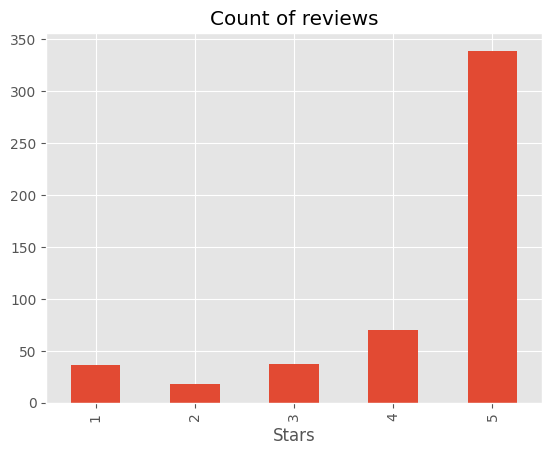

In [5]:
ax=df['Score'].value_counts().sort_index().plot(kind='bar',title='Count of reviews')
ax.set_xlabel('Stars')
plt.show()

In [8]:
#VADER-SENTIMENT ANALYSIS

In [9]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm import tqdm 
sia=SentimentIntensityAnalyzer()
#Running polarity scores on entire dataset
res={}
for i,row in tqdm(df.iterrows(),total=len(df)):
    myid=row['Id']
    text=row['Text']
    res[myid]=sia.polarity_scores(text)

100%|██████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 1201.91it/s]


In [10]:
vaders=pd.DataFrame(res).T
vaders=vaders.reset_index().rename(columns={'index':'Id'})
vaders=vaders.merge(df,how='left')


In [11]:
vaders.head()

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


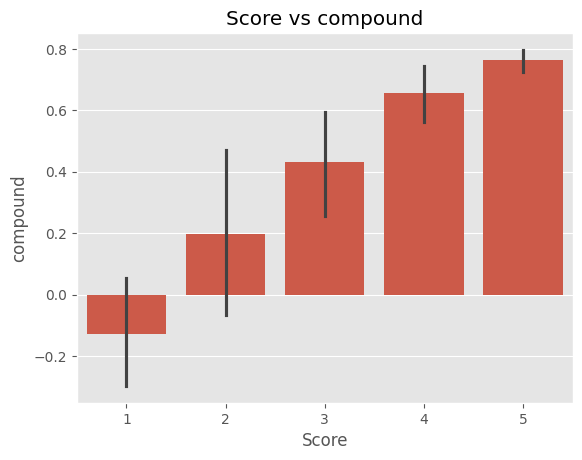

In [12]:
axis=sns.barplot(data=vaders,x='Score',y='compound')
axis.set_title('Score vs compound')
plt.show()

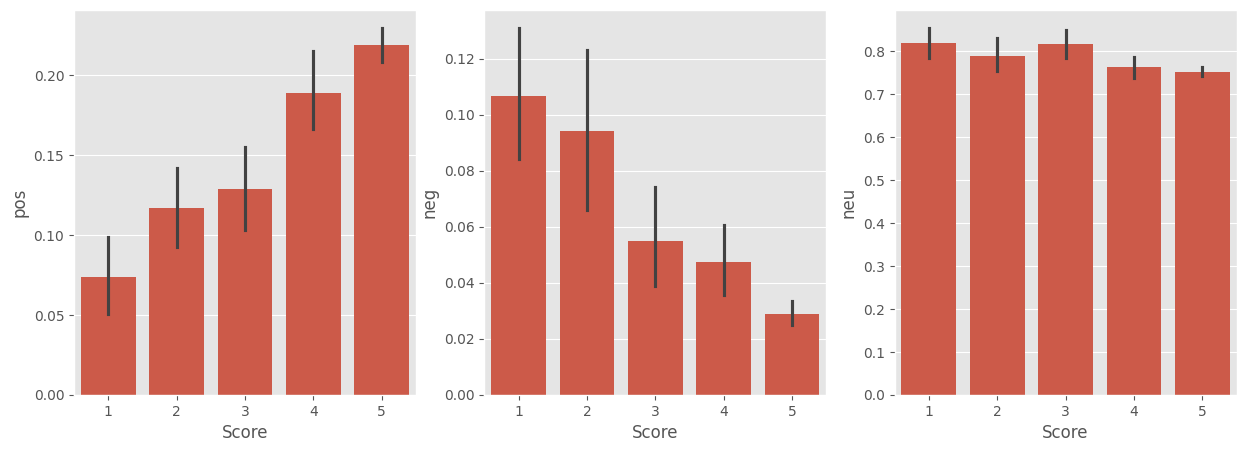

In [13]:
#PLOTTING POS,NEG,NEU
fig,axis=plt.subplots(1,3,figsize=(15,5))
sns.barplot(data=vaders,x='Score',y='pos',ax=axis[0])
sns.barplot(data=vaders,x='Score',y='neg',ax=axis[1])
sns.barplot(data=vaders,x='Score',y='neu',ax=axis[2])
plt.show()


In [15]:
#Using transformers

In [16]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax
import torch

In [17]:
model = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer=AutoTokenizer.from_pretrained(model)
model=AutoModelForSequenceClassification.from_pretrained(model)

In [18]:
encoded=tokenizer(eg,return_tensors='pt')
output=model(**encoded)
scores=output[0][0].detach().numpy()
scores=softmax(scores)
scores_dict={'rob_neg':scores[0],'rob_neu':scores[1],'rob_pos':scores[2]}
print(scores_dict)

D:\anaconda\envs\loan_default_env\lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


{'rob_neg': np.float32(0.97635514), 'rob_neu': np.float32(0.020687466), 'rob_pos': np.float32(0.0029573692)}


In [19]:
#For entire data

In [20]:
def roberta_scores(example):
    encoded=tokenizer(eg,return_tensors='pt')
    output=model(**encoded)
    scores=output[0][0].detach().numpy()
    scores=softmax(scores)
    scores_dict={'rob_neg':scores[0],'rob_neu':scores[1],'rob_pos':scores[2]}
    return scores_dict

In [21]:
res={}
for i,row in tqdm(df.iterrows(),total=len(df)):
    myid=row['Id']
    text=row['Text']
    vader_res=sia.polarity_scores(text)
    vader_res_rename={}
    for key,val in vader_res.items():
        vader_res_rename[f"vader_{key}"]=val
    rob_res=roberta_scores(text)
    both={**vader_res_rename,**rob_res}
    res[myid]=both

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:29<00:00, 16.95it/s]


In [22]:
res_df=pd.DataFrame(res).T
res_df=res_df.reset_index().rename(columns={'index':'Id'})
res_df=res_df.merge(df,how='left')
res_df

                                   

,Id,vader_neg,vader_neu,vader_pos,vader_compound,rob_neg,rob_neu,rob_pos,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,0.976355,0.020687,0.002957,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,0.976355,0.020687,0.002957,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,0.976355,0.020687,0.002957,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,0.976355,0.020687,0.002957,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,0.976355,0.020687,0.002957,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,496,0.000,0.554,0.446,0.9725,0.976355,0.020687,0.002957,B000G6RYNE,APGAA43E3WPN7,Darren,0,0,5,1201392000,amazing chips,i rarely eat chips but i saw these and tried t...
496,497,0.059,0.799,0.142,0.7833,0.976355,0.020687,0.002957,B000G6RYNE,ABR7HU5H1KNE,Keith,0,0,5,1196726400,Best Chip Ever,This is easily the best potato chip that I hav...
497,498,0.025,0.762,0.212,0.9848,0.976355,0.020687,0.002957,B000G6RYNE,AJQD2WWJYOYFQ,bubbles,0,0,4,1186617600,"Tangy, spicy, and sweet- oh my!",Kettle Chips Spicy Thai potato chips have the ...
498,499,0.041,0.904,0.055,0.1280,0.976355,0.020687,0.002957,B000G6RYNE,A16YH487W9ZYO0,Bruce G. Lindsay,0,0,4,1184198400,An indulgence with a bite,"Okay, I should not eat potato chips, nor shoul..."


In [ ]:
#Conclusion

In [24]:
print("""Conclusion:
- VADER sentiment trends align with review scores, with more positive sentiment for higher scores.
- RoBERTa captures more nuanced sentiment and works well on short texts.
- Combining both methods provides deeper insights into review content.
""")

Conclusion:
- VADER sentiment trends align with review scores, with more positive sentiment for higher scores.
- RoBERTa captures more nuanced sentiment and works well on short texts.
- Combining both methods provides deeper insights into review content.

